In [1]:
from chebGreen import ChebGreen
import numpy as np
import matplotlib.pyplot as plt

from chebGreen.chebpy2 import Quasimatrix
from chebGreen.chebpy2.chebpy import chebfun
from chebGreen.chebpy2 import Chebfun2

# %env TF_MLC_LOGGING=1
# %env TF_CPP_MIN_LOG_LEVEL=2

In [2]:
airy = ChebGreen([1,5,10], generateData = True, script = "generate_example", example = "airy_equation")

Generating dataset for example 'airy_equation'
Dataset found for Theta = 1.00. Skipping dataset generation.
Dataset found for Theta = 5.00. Skipping dataset generation.
Dataset found for Theta = 10.00. Skipping dataset generation.
-------------------------------------------------------------------------------

Generating chebfun2 models:
Found saved model, Loading model for example 'airy_equation' at Theta = 1.00
Learning a chebfun2 model for example 'airy_equation' at Theta = 1.00
Chebfun2 model added for example 'airy_equation' at Theta = 1.00

Found saved model, Loading model for example 'airy_equation' at Theta = 5.00
Learning a chebfun2 model for example 'airy_equation' at Theta = 5.00
Chebfun2 model added for example 'airy_equation' at Theta = 5.00

Found saved model, Loading model for example 'airy_equation' at Theta = 10.00
Learning a chebfun2 model for example 'airy_equation' at Theta = 10.00
Chebfun2 model added for example 'airy_equation' at Theta = 10.00



In [3]:
airy.G

{1.0: chebfun2 object
      domain       rank               corner values
 [0,1] x [0,1]     59       [-0.000 -0.000 -0.000 -0.000]
 vertical scale = 0.238198,
 5.0: chebfun2 object
      domain       rank               corner values
 [0,1] x [0,1]     59       [-0.000 -0.000 -0.000 -0.000]
 vertical scale = 0.138575,
 10.0: chebfun2 object
      domain       rank               corner values
 [0,1] x [0,1]     59       [0.000 -0.000 -0.000 -0.000]
 vertical scale = 0.087169}

Text(0, 0.5, 's')

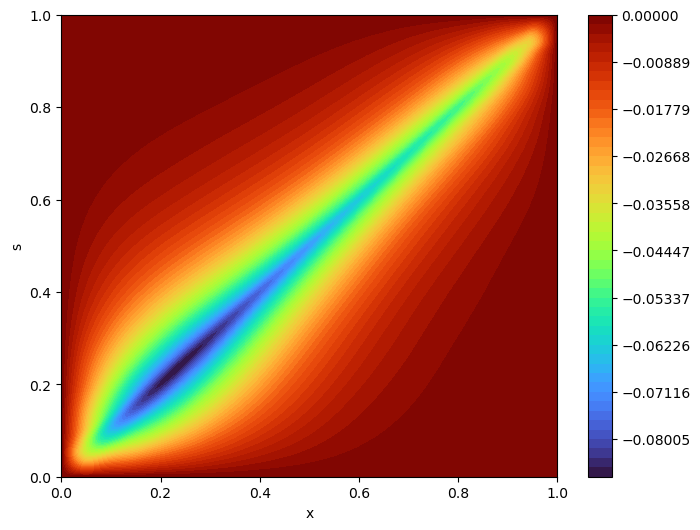

In [4]:
fig = plt.figure(figsize = (8,6))
airy.G[10].plot(fig = fig, ax = plt.gca())
plt.xlabel('x')
plt.ylabel('s')

In [5]:
%%time
u,s,v = airy.G[1].svd()

CPU times: user 3.91 s, sys: 7.21 s, total: 11.1 s
Wall time: 1.67 s


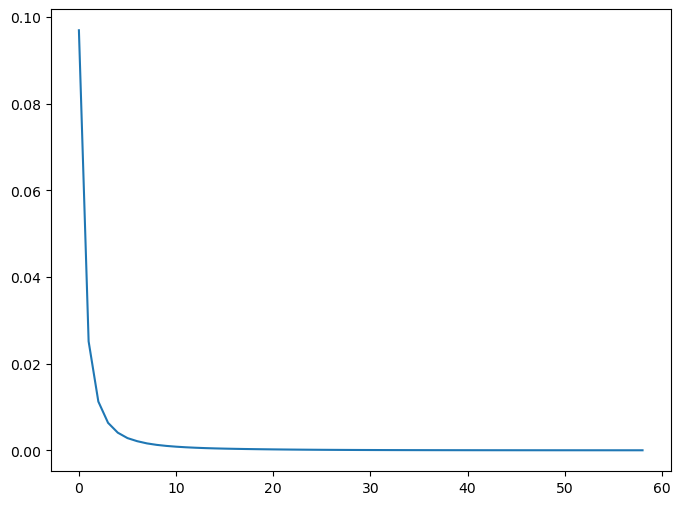

In [6]:
fig = plt.figure(figsize = (8,6))
plt.plot(s)

(0.0, 1.0)

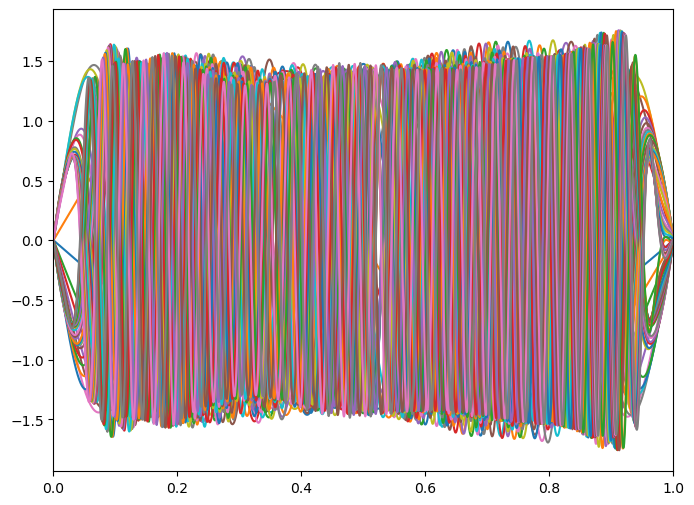

In [7]:
# i = slice(10,20)
i = slice(0,-1)
# i = 16
fig = plt.figure(figsize = (8,6))
u[:,i].plot(fig = fig)
# print(np.max(u[:,i].vscale))
# plt.title(f'First {i+1} left singular functions for a Laplacian')
plt.xlim([0,1])
# fig.savefig(f'Laplace-first.png', dpi = fig.dpi)

In [8]:
%%time
theta_ = 7.0
G7 = airy.generateNewModel(theta_)

CPU times: user 25.9 s, sys: 29 s, total: 55 s
Wall time: 8.6 s


In [9]:
validation = ChebGreen([7], generateData = True, script = "generate_example", example = "airy_equation")

Generating dataset for example 'airy_equation'
Dataset found for Theta = 7.00. Skipping dataset generation.
-------------------------------------------------------------------------------

Generating chebfun2 models:
Found saved model, Loading model for example 'airy_equation' at Theta = 7.00
Learning a chebfun2 model for example 'airy_equation' at Theta = 7.00
Chebfun2 model added for example 'airy_equation' at Theta = 7.00



In [32]:
def compareGreen1D(interpModel, exactModel, vmin = None, vmax = None):
    domain = interpModel.domain
    xx = np.linspace(domain[2],domain[3],2000)
    yy = np.linspace(domain[0],domain[1],2000)
    x, s = np.meshgrid(xx,yy)
    
    if vmin is None:
        vmin = min(interpModel.min,exactModel.min)
    if vmax is None:
        vmax = max(interpModel.max,exactModel.max)
        
    plt.figure(figsize = (16,6))
    plt.subplot(121)
    
    GInterp = interpModel[x,s]
    
    levels = np.linspace(vmin, vmax, 50, endpoint = True)
    ticks = np.linspace(vmin, vmax, 10, endpoint=True)
    
    surf = plt.contourf(x, s, GInterp, levels = levels, cmap = 'turbo', vmin = vmin, vmax = vmax)
    plt.gca().set_aspect('equal', adjustable='box')
    cbar = plt.colorbar(ticks = ticks, fraction = 0.046, pad = 0.04)
    cbar.ax.set_yticklabels(["{:4.2f}".format(i) for i in ticks])
    plt.xlabel('$x$', fontsize = 11)
    plt.ylabel('$s$', rotation='horizontal', labelpad=10, fontsize = 11)
    plt.title("Interpolated", fontsize = 14)
    
    GExact = exactModel[x,s]
    
    plt.subplot(122)
    plt.gca().set_aspect('equal', adjustable='box')
    surf = plt.contourf(x, s, GExact, levels = levels, cmap = 'turbo', vmin = vmin, vmax = vmax)
    cbar = plt.colorbar(ticks = ticks, fraction = 0.046, pad = 0.04)
    cbar.ax.set_yticklabels(["{:4.2f}".format(i) for i in ticks])
    plt.xlabel('x', fontsize = 11)
    plt.ylabel('s', rotation='horizontal', labelpad=10, fontsize = 11)
    plt.title("Data", fontsize = 14)

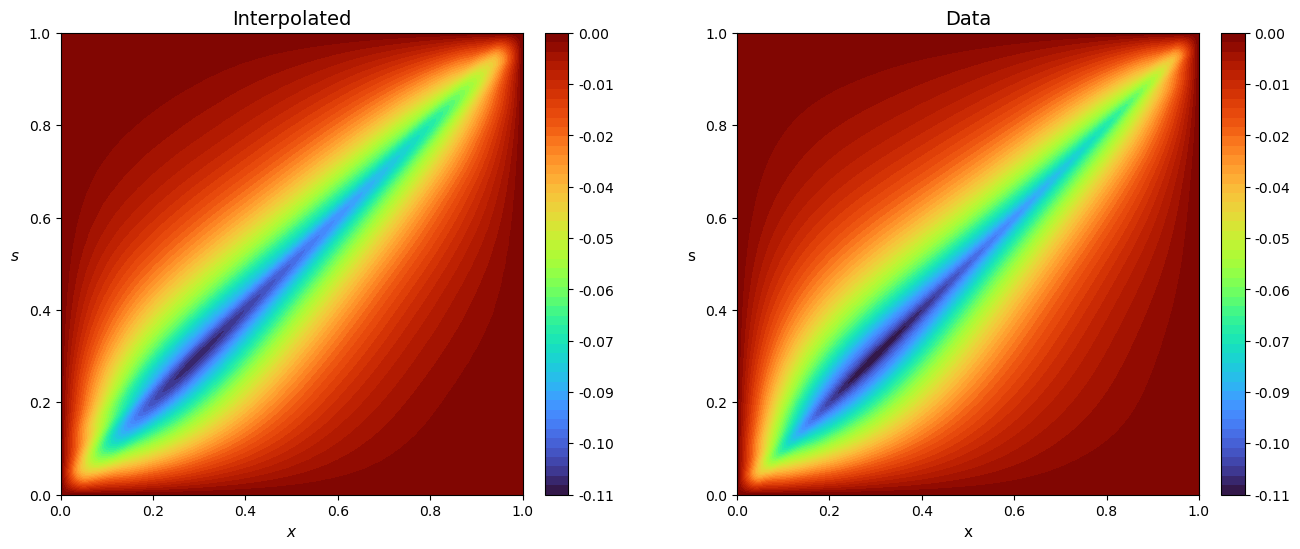

In [33]:
compareGreen1D(G7,validation.G[7])